# Driver for VAE
- We will use a Variational Autoencoder to generate more malignant data

In [5]:
import numpy as np
import pandas as pd
import os
import h5py
import cv2
import matplotlib.pyplot as plt
import tqdm
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
#TODO: change this to your own directory
# current_dir = "/Users/thatblue340/Documents/Documents/GitHub/EECS-545-final-project"
current_dir = ""

In [6]:
from vae import CVAE
from torch import nn

## Data Loading
- Load images to train VAE

In [7]:
train_metadata = pd.read_csv(os.path.join(current_dir,'train-metadata.csv'),low_memory=False)
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [8]:
test_metadata = pd.read_csv(os.path.join(current_dir,'test-metadata.csv'),low_memory=False)
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   isic_id                      3 non-null      object 
 1   patient_id                   3 non-null      object 
 2   age_approx                   3 non-null      float64
 3   sex                          3 non-null      object 
 4   anatom_site_general          3 non-null      object 
 5   clin_size_long_diam_mm       3 non-null      float64
 6   image_type                   3 non-null      object 
 7   tbp_tile_type                3 non-null      object 
 8   tbp_lv_A                     3 non-null      float64
 9   tbp_lv_Aext                  3 non-null      float64
 10  tbp_lv_B                     3 non-null      float64
 11  tbp_lv_Bext                  3 non-null      float64
 12  tbp_lv_C                     3 non-null      float64
 13  tbp_lv_Cext             

In [13]:
# training_validation_hdf5 = h5py.File(f"{current_dir}/train-image.hdf5", 'r')
# testing_hdf5 = h5py.File(f"{current_dir}/test-image.hdf5", 'r')
training_validation_hdf5 = h5py.File("train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"test-image.hdf5", 'r')

## Preprocess data
- Only take the malignant images
- Resize them to (128, 128, 3)
- Normalize pixel values to [0,1]

In [14]:
# import training images 
train_images = []
for i in tqdm.tqdm(range(len(train_metadata))):
    if train_metadata.iloc[i]['target'] == 0: # skip non-target images
        continue
    image_id = train_metadata.iloc[i]['isic_id']
    image = training_validation_hdf5[image_id][()]
    image = np.frombuffer(image, dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (128, 128))
    image = image / 255
    train_images.append(image)
train_images = np.array(train_images)


print(f"Training images shape: {train_images.shape}")

100%|██████████| 401059/401059 [00:20<00:00, 19552.61it/s]


Training images shape: (393, 128, 128, 3)


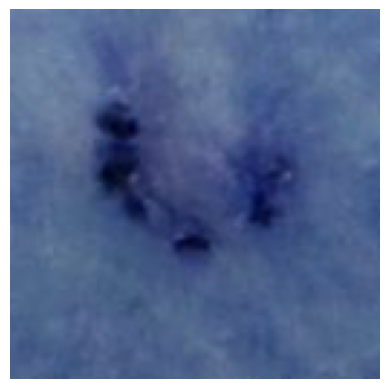

In [15]:
plt.imshow(train_images[0])
plt.axis('off') 
plt.show()

## Setup for Dataset to be used for diffusion model

In [16]:
class MalignantDataset(torch.utils.data.Dataset):
    def __init__(self, image_array):
        self.images = image_array
        self.transform = transforms.Compose([
            transforms.ToPILImage(),                     # must come before Resize
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
            transforms.ToTensor(),                      # converts to torch.FloatTensor (float32)
            transforms.Normalize((0.5,), (0.5,))         # [-1, 1] range
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # shape: (128, 128, 3), dtype: np.uint8 or float
        image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image  # ensure proper dtype
        return self.transform(image)

In [17]:
malignant_dataset = MalignantDataset(train_images)
malignant_loader = DataLoader(malignant_dataset, batch_size=32, shuffle=True)

## Train using diffusion model

In [30]:
from denoising_diffusion_pytorch import GaussianDiffusion, Unet

model = Unet(
    dim=128,
    dim_mults=(1, 2, 4, 8),
    channels=3
)

diffusion = GaussianDiffusion(
    model,
    image_size=128,
    timesteps=1000,  # number of diffusion steps
    objective='pred_x0',  # loss objective
)
optimizer = torch.optim.Adam(diffusion.parameters(), lr=2e-4)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from tqdm import tqdm
import time

model.train()
diffusion.to(device)
step = 0
max_steps = 8000
pbar = tqdm(total=max_steps, desc="Training DDPM", ncols=100)

while step < max_steps:
    for images in malignant_loader:
        images = images.to(device)
        loss = diffusion(images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 500 == 0:
            print(f"[{time.strftime('%H:%M:%S')}] Step {step} | Loss: {loss.item():.4f}")
            torch.save({
                'model_state_dict': model.state_dict(),
                'diffusion_state_dict': diffusion.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'step': step  # optional: useful for resume
            }, f'saved_models/diffusion_checkpoint_{step}.pth')
            
        step += 1
        pbar.update(1)
        if step >= max_steps:
            break
pbar.close()

Training DDPM:   0%|                                                       | 0/8000 [00:17<?, ?it/s]


[01:02:14] Step 0 | Loss: 22.6279


Training DDPM:   0%|▏                                           | 26/8000 [00:37<2:14:04,  1.01s/it]

## Generate and visualize images

In [ ]:
# Generate 
model.eval()
diffusion.eval()

In [ ]:
num_samples = 10
with torch.no_grad():
    samples = diffusion.sample(batch_size=num_samples)

In [ ]:
# Convert from [-1, 1] to [0, 1]
samples = (samples + 1) / 2
samples = samples.clamp(0, 1).cpu()

# Plot images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    img = samples[i].permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
    axes[i].imshow(img)
    axes[i].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import torchvision.transforms.functional as TF

for i, img in enumerate(samples):
    img_pil = TF.to_pil_image(img)
    img_pil.save(f"gen_image_{i:03}.png")